# Segmenting and clustering neighbourhoods in Toronto

## 1. Scrape a table from Wikipedia: _List of postal codes of Canada: M_


First, we import some libraries.

In [1]:
import requests #to get a raw html page
from bs4 import BeautifulSoup #a scraping package
import pandas as pd #to work with dataframes

Get the html page.

In [2]:
raw_page=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup=BeautifulSoup(raw_page.text,'lxml')

Get the table from it.

In [3]:
table=soup.find_all('table')[0]

Preprocess the table before merge with geospatial data.

In [4]:
df=pd.read_html(str(table), header=0)[0] #read table by Pandas
df=df[df.Borough !='Not assigned'] #drop rows with 'Not assigned' in Borough
df = df.reset_index(drop=True) #reset index 0, 1, 2, ...
#Combine neighbourhoods with same postcode and borough
df=df.groupby(['Postcode','Borough'], as_index=False).agg(lambda x: ', '.join(set(x.dropna()))) 
#'Not assigned' neighborhoods are changed to their boroughs
df.loc[df.Neighbourhood=='Not assigned', 'Neighbourhood']=df.Borough
#Show first rows of table after preprocessing
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Morningside, Guildwood, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


The table size after preprocessing is 

In [5]:
df.shape

(103, 3)

# 2. Add coordinate to Neighbourhoods

Load geospatial data from a csv file.

In [6]:
df_coordinate=pd.read_csv('http://cocl.us/Geospatial_data')

The column _Postal Code_ in the csv file is the same as the column _Postcode_ in the dataframe. So we change the name _Postal Code_ into _Postcode_ so that we can merge later. 

In [7]:
df_coordinate.rename(columns={'Postal Code':'Postcode'},inplace=True)

Merge 2 dataframes.

In [8]:
df_merge=pd.merge(df,df_coordinate)
df_merge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# 3. Clustering Toronto by k-Mean 

Let's import some libraries.

In [9]:
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

From now on, we only work with bouroughs containing 'Toronto'.

In [10]:
df_toronto = df_merge[df_merge['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


We get coordinates of Toronto as follows.

In [11]:
geolocator = Nominatim(user_agent="explore_toronto")
location = geolocator.geocode('Toronto')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto neighbourhoods.

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Now, we use Foursquare to explore Toronto venues.

My Foursquare account is as follows. 

In [13]:
CLIENT_ID = 'Z4VG3VCWSTJUXART5WHOTKDW41LAG4EKZGF2KCMTJH1JCYDN' # my Foursquare ID
CLIENT_SECRET = 'SH54J1GTZF3JN4V3XL4OXZCNZF12DWINXW23JO1FID0MZE4N' # my Foursquare Secret
VERSION = '20190202' # Foursquare API version

Set limit and radius to search.

In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Let's define a function to get nearby venues.

In [15]:
   def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

List of Toronto venues.

In [16]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

The Beaches
Riverdale, The Danforth West
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Summerhill East, Moore Park
Summerhill West, Forest Hill SE, Deer Park, South Hill, Rathnelly
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, Richmond, King
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill West, Forest Hill North
Yorkville, The Annex, North Midtown
University of Toronto, Harbord
Kensington Market, Grange Park, Chinatown
South Niagara, Bathurst Quay, King and Spadina, Railway Lands, CN Tower, Harbourfront West, Island airport
Stn A PO Boxes 25 The Esplanade
Underground city, First Canadian Place
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Exhibition Place, Parkdale Village, Brockton
High Park, The 

Use one-hot encoding to transform venues to numeric variables.

In [17]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [18]:
# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Riverdale, The Danforth West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Groupby neighbourhoods in Toronto.

In [19]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, Richmond, King",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,...,0.0,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.01,0.000000
1,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000
2,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012346,...,0.0,0.0,0.0,0.012346,0.0,0.0,0.012346,0.0,0.00,0.012346
4,Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000


Before clustering, let's drop the column 'Neighbourhood'.

In [20]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

Next, we choose k in k-Mean method.

In [21]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

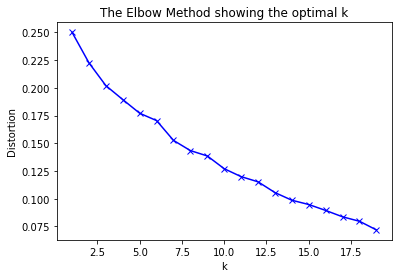

In [23]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

From the elbow method, we choose k=7.

In [24]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       3, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 0, 0, 0, 0], dtype=int32)

Add cluster labels to Toronto neighbourhoods.

In [25]:
df_toronto.insert(0, 'Cluster Labels', kmeans.labels_)
df_toronto.head()

,Cluster Labels,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,0,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,0,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,0,M4M,East Toronto,Studio District,43.659526,-79.340923
4,0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Visualize the clusters.

In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters